In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import subprocess
import shlex
import os
import pandas as pd
import cPickle as pickle
import caffe
#    Put matlab on path for selective search detection
os.environ["PATH"] += ':/Applications/MATLAB_R2014b.app/bin'
%matplotlib inline

In [2]:
'''
Created on May 1, 2015

    Hybrid NN for featurization / SVM or other for classification
    The topmost classifier is called the ``head''.

@author: Francois Belletti
'''

import numpy as np
import sklearn as sk
import caffe
import cPickle as pickle

caffe.set_mode_gpu()
caffe.set_device(0)

class Hybrid_classifier:
    
    #
    #    Instantiates caffe model and head classifier
    #    @param model_filepath     String path to caffe model prototxt
    #    @param weight_filepath    String path to model's weights
    #    @param head_filepath      String path to shallow featurizer
    #    @param label_lookup       String path to label lookup table
    #    @param mean_path          String path to mean image
    def __init__(self, model_filepath, 
                 weight_filepath,
                 head_filepath = None, 
                 label_lookup = None,
                 mean_path = 'ilsvrc_2012_mean.npy',
                 context_pad = 16):
        #    Setup neural net
        self.net            =   caffe.Net(model_filepath, weight_filepath, caffe.TEST)
        #    Setup ``head'' if needed
        if head_filepath is not None:
            self.head           =   pickle.load(open(head_filepath, 'rb'))
        else:
            self.head           =   None
        #    Setup label lookup table if needed
        if label_lookup is not None:
            self.label_to_num   =   pickle.load(open(label_lookup, 'rb'))
            self.num_to_label   =   dict(zip(self.label_to_num.values(), self.label_to_num.keys()))
        else:
            self.label_to_num   =   None
            self.num_to_label   =   None
        #    Setup image transformations
        self.mean_image     =   np.load(mean_path)
        self.transformer    =   caffe.io.Transformer({'data': self.net.blobs['data'].data.shape})
        self.transformer.set_mean('data', np.load(mean_path).mean(1).mean(1))
        self.transformer.set_transpose('data', (2,0,1))
        self.transformer.set_channel_swap('data', (2,1,0))
        self.transformer.set_raw_scale('data', 255.0)
        self.context_pad = context_pad
        self.configure_crop(context_pad)
    
    #
    #    Featurize a given image, works with a file path or an image
    #
    def featurize(self, input_image, target_layers = ['fc7']):
        if type(input_image) is str:
            im = caffe.io.load_image(input_image)
            out = self.net.forward_all(target_layers, 
                                       data = np.asarray([self.transformer.preprocess('data', im)]))
        else:
            out = self.net.forward_all(target_layers, 
                                       data = np.asarray([self.transformer.preprocess('data', input_image)]))
        return [out[x] for x in target_layers]
    
    #
    #    Classify a given image, works with a file path or an image
    #
    def classify_with_head(self, input_image, target_feature, log_probas = False):
        target_layers = [target_feature]
        if type(input_image) is str:
            im  = caffe.io.load_image(input_image)
            out = self.featurize(im, target_layers)
        else:
            out = self.featurize(input_image, target_layers)
        feature_vect = out[0]
        if not log_probas:
            return self.head.predict(feature_vect)
        else:
            return self.head.predict_proba(feature_vect)
        
    def classify_pure_NN(self, input_image, log_probas = False):
        out = self.net.forward_all(data = np.asarray([self.transformer.preprocess('data', input_image)]))
        probas = out.values()[-1]
        if log_probas:
            return np.log(probas)
        else:
            return np.argmax(probas)
        
    def classify(self, input_image, log_probas = False, target_feature = None):
        if self.head is not None:
            return self.classify_with_head(input_image, target_feature, log_probas)
        else:
            return self.classify_pure_NN(input_image, log_probas)
        
    def classify_windows(self, images_windows, feature_layer = 'fc7'):
        """
        Do windowed detection over given images and windows. Windows are
        extracted then warped to the input dimensions of the net.

        Take
        images_windows: (image filename, window list) iterable.
        context_crop: size of context border to crop in pixels.

        Give
        detections: list of {filename: image filename, window: crop coordinates,
            predictions: prediction vector} dicts.
        """
        # Extract windows.
        window_inputs = []
        for image_fname, windows in images_windows:
            image = caffe.io.load_image(image_fname).astype(np.float32)
            for window in windows:
                window_inputs.append(self.crop(image, window))

        # Run through the net (warping windows to input dimensions).
        in_ = self.net.inputs[0]
        caffe_in = np.zeros((len(window_inputs), window_inputs[0].shape[2])
                            + self.net.blobs[in_].data.shape[2:],
                            dtype=np.float32)
        for ix, window_in in enumerate(window_inputs):
            caffe_in[ix] = self.transformer.preprocess(in_, window_in)
        if self.head is None:
            out = self.net.forward_all(**{in_: caffe_in})
            #        predictions = out[self.outputs[0]].squeeze(axis=(2,3))
            predictions = out[self.net.outputs[0]].squeeze() # https://github.com/BVLC/caffe/issues/2041
        else:
            out = self.net.forward_all([feature_layer], **{in_: caffe_in})
            #
            feature_vects = out[feature_layer].squeeze()
            #
            predictions = self.head.predict_proba(feature_vects)
            
        # Package predictions with images and windows.
        detections = []
        ix = 0
        for image_fname, windows in images_windows:
            for window in windows:
                detections.append({
                    'window': window,
                    'prediction': predictions[ix],
                    'filename': image_fname
                })
                ix += 1
        return detections

        
    def lookup(self, label): 
        if type(label) is str:
            return self.label_to_num[label]
        else:
            return self.num_to_label[int(label)]
        
    def crop(self, im, window):
        """
        Crop a window from the image for detection. Include surrounding context
        according to the `context_pad` configuration.

        Take
        im: H x W x K image ndarray to crop.
        window: bounding box coordinates as ymin, xmin, ymax, xmax.

        Give
        crop: cropped window.
        """
        # Crop window from the image.
        crop = im[window[0]:window[2], window[1]:window[3]]

        if self.context_pad:
            box = window.copy()
            crop_size = self.net.blobs[self.net.inputs[0]].width  # assumes square
            scale = crop_size / (1. * crop_size - self.context_pad * 2)
            # Crop a box + surrounding context.
            half_h = (box[2] - box[0] + 1) / 2.
            half_w = (box[3] - box[1] + 1) / 2.
            center = (box[0] + half_h, box[1] + half_w)
            scaled_dims = scale * np.array((-half_h, -half_w, half_h, half_w))
            box = np.round(np.tile(center, 2) + scaled_dims)
            full_h = box[2] - box[0] + 1
            full_w = box[3] - box[1] + 1
            scale_h = crop_size / full_h
            scale_w = crop_size / full_w
            pad_y = round(max(0, -box[0]) * scale_h)  # amount out-of-bounds
            pad_x = round(max(0, -box[1]) * scale_w)

            # Clip box to image dimensions.
            im_h, im_w = im.shape[:2]
            box = np.clip(box, 0., [im_h, im_w, im_h, im_w])
            clip_h = box[2] - box[0] + 1
            clip_w = box[3] - box[1] + 1
            assert(clip_h > 0 and clip_w > 0)
            crop_h = round(clip_h * scale_h)
            crop_w = round(clip_w * scale_w)
            if pad_y + crop_h > crop_size:
                crop_h = crop_size - pad_y
            if pad_x + crop_w > crop_size:
                crop_w = crop_size - pad_x

            # collect with context padding and place in input
            # with mean padding
            context_crop = im[box[0]:box[2], box[1]:box[3]]
            context_crop = caffe.io.resize_image(context_crop, (crop_h, crop_w))
            crop = np.ones(self.crop_dims, dtype=np.float32) * self.crop_mean
            crop[pad_y:(pad_y + crop_h), pad_x:(pad_x + crop_w)] = context_crop
        #
        return crop
    
    
    def configure_crop(self, context_pad):
        """
        Configure crop dimensions and amount of context for cropping.
        If context is included, make the special input mean for context padding.

        Take
        context_pad: amount of context for cropping.
        """
        # crop dimensions
        in_ = self.net.inputs[0]
        tpose = self.transformer.transpose[in_]
        inv_tpose = [tpose[t] for t in tpose]
        self.crop_dims = np.array(self.net.blobs[in_].data.shape[1:])[inv_tpose]
        #.transpose(inv_tpose)
        # context padding
        self.context_pad = context_pad
        if self.context_pad:
            in_ = self.net.inputs[0]
            transpose = self.transformer.transpose.get(in_)
            channel_order = self.transformer.channel_swap.get(in_)
            raw_scale = self.transformer.raw_scale.get(in_)
            # Padding context crops needs the mean in unprocessed input space.
            mean = self.transformer.mean.get(in_)
            if mean is not None:
                inv_transpose = [transpose[t] for t in transpose]
                crop_mean = mean.copy().transpose(inv_transpose)
                if channel_order is not None:
                    channel_order_inverse = [channel_order.index(i)
                                            for i in range(crop_mean.shape[2])]
                    crop_mean = crop_mean[:,:, channel_order_inverse]
                if raw_scale is not None:
                    crop_mean /= raw_scale
                self.crop_mean = crop_mean
            else:
                self.crop_mean = np.zeros(self.crop_dims, dtype=np.float32)

In [3]:
#Setting up source images

source_folder = '../cam_imgs/'
filenames = os.listdir(source_folder)
median_pict_name = filter(lambda x : 'median' in x, filenames)[0]
frames = filter(lambda x : x not in ['high_image.jpg', 'low_image.jpg', 'median_image.jpg', 'std_image.jpg'], filenames)

background = cv2.imread(source_folder + median_pict_name)

In [4]:
# Build lookup table for labels

lookup_table    = pickle.load(open('../image_dump/label_lookup_table.pi', 'rb'))
labels = [x[0] for x in sorted(lookup_table.items(), key = (lambda x : x[1]))]
print labels

['background', 'person', 'bicycle', 'bus', 'car', 'motorbike']


In [5]:
# Build detector with our finetuned net
model_file      = '../finetuning/rcc_net/deploy_nn_background.prototxt'
model_weights   = '../finetuning/rcc_net/background/caffenet_train_background_iter_10000.caffemodel' 
mean_image      = '../finetuning/ilsvrc_2012_mean.npy'

#
#    The default arguments have been picked from caffe's detect.py script
#
channel_swap = (2, 1, 0)
raw_scale = 255
context_pad = 16

mean = np.load(mean_image).mean(1).mean(1)

detector = caffe.Detector(model_file, model_weights, 
                          mean = mean,
                          raw_scale = raw_scale,
                          channel_swap = channel_swap,
                          context_pad = context_pad)

In [6]:
#
#    Extract bounding boxes from pre-processed image
#
#    @param seg A gray scale image
#    @param thr The threshold value (90 to 110 is reasonnable) for contour detection
#    @param blur Blur radius in number of pixels
#
#    @return List of bounding box coordinates (cv2 rectangles)
#
def get_bbx(image, background, thr = 100, blur = 6, heuristic = False):
    #
    #   Compute aspect ratio parameters
    #
    original_width = image.shape[1]
    original_height = image.shape[0]
    aspect_ratio = float(original_width) / float(original_height)
    min_aspect_ratio = 0.1
    max_aspect_ratio = 10.0
    #
    # Parameters to play around with
    #
    min_width_bounding_rect = 10
    min_height_bounding_rect = 10
    min_width_ratio_padding = .25
    min_width_pixel_padding = 20
    min_height_ratio_padding = aspect_ratio * .25
    min_height_pixel_padding = aspect_ratio * 20
    #
    #    Normalized picture
    #
    seg      = image.mean(-1) - background.mean(-1)
    norm_pct =  np.copy(seg)
    norm_pct += np.abs(np.min(norm_pct))
    norm_pct =  255.0 * norm_pct / float(np.max(norm_pct) - np.min(norm_pct))
    norm_pct =  norm_pct.astype(np.uint8)
    #
    #    Blur the picture
    #
    blurred_pct = cv2.blur(norm_pct, (blur, blur))
    #
    #    Extract thresholds
    #
    ret, thresh1 = cv2.threshold(blurred_pct, thr, 255, cv2.THRESH_TOZERO_INV)
    ret, thresh2 = cv2.threshold(blurred_pct, 255 - thr, 255, cv2.THRESH_TOZERO)
    thresh = np.zeros(norm_pct.shape, dtype = np.uint8)
    thresh[:] = ((thresh1 + thresh2) * 0.5 )[:]
    #
    #    Extract contours
    #
    contours, hier = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #
    #    Filter out child contours
    #
    boxes = []
    kept_contours = []
    for i in range(len(contours)):
        rect = cv2.boundingRect(contours[i])
        x, y, w, h = rect
        if heuristic:
            if hier[0,i,3] >= 0:
                # Check if contour has parent. If so, skip
                continue
            # skip boxes that are too small:
            if w < min_width_bounding_rect or h < min_height_bounding_rect:
                continue
            window_aspect_ratio = float(w) / float(h)
            print window_aspect_ratio
            if (window_aspect_ratio < min_aspect_ratio):
                continue # The window is too tall
            if (window_aspect_ratio > max_aspect_ratio):
                continue # The window is too wide
            const_x = max(min_width_ratio_padding * w, min_width_pixel_padding)
            const_y = max(min_height_ratio_padding * h, min_height_pixel_padding)
            y_b = max(y - const_y, 0)
            y_e = min(y + h + const_y, original_heigth)
            x_b = max(x - const_x, 0)
            x_e = min(x + w + const_x, original_width)
            boxes.append(np.array([y_b, x_b, y_e, x_e]))
        else:
            boxes.append(np.array([y, x, y + h, x + w]))
        kept_contours.append(i)
    #
    #    Return list of contours
    #
    return np.asarray(boxes)

nms_overlap_threshold = .4

# http://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
# Malisiewicz et al.
def non_max_suppression_fast(boxes, overlapThresh = nms_overlap_threshold):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes    
    pick = []

    # grab the coordinates of the bounding boxes
    y1 = boxes[:,0]
    x1 = boxes[:,1]
    y2 = boxes[:,2]
    x2 = boxes[:,3]

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick].astype("int"), pick

In [7]:
# Detect objects with our custom made detector
def get_regions(detector, input_images):
    #bbxes = get_bbx(input_image, background, heuristic = True)
    #bbxes, _ = non_max_suppression_fast(bbxes)
    #bbxes = [[fname, bbxes]]
    print 'Begining detection'
    regions = detector.get_windows(input_images, quick = True)
    print 'Detection done'
    #detections = detector.detect_windows(bbxes)
    return regions

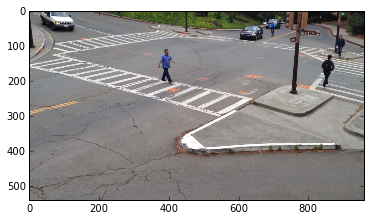

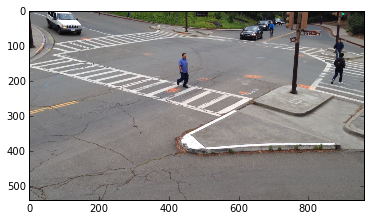

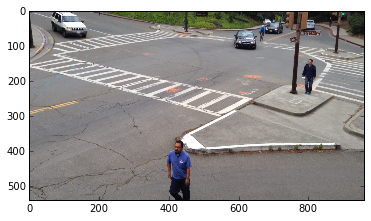

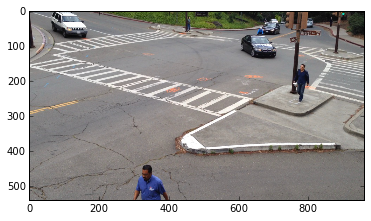

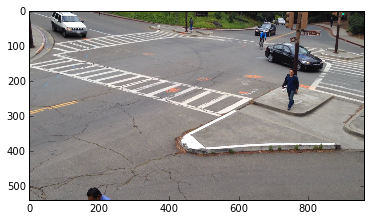

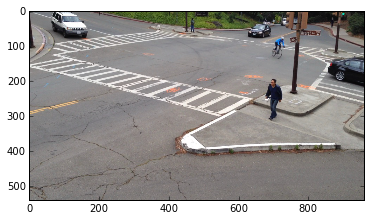

Begining detection
selective_search({'/Users/francois/smartCams/Wksp/smartCams/cam_imgs/0.jpg','/Users/francois/smartCams/Wksp/smartCams/cam_imgs/1.jpg','/Users/francois/smartCams/Wksp/smartCams/cam_imgs/10.jpg','/Users/francois/smartCams/Wksp/smartCams/cam_imgs/11.jpg','/Users/francois/smartCams/Wksp/smartCams/cam_imgs/12.jpg','/Users/francois/smartCams/Wksp/smartCams/cam_imgs/13.jpg'}, '/var/folders/ql/45s6v60x42q7n3f0vk3v2db40000gn/T/tmpqzDUsU.mat')
matlab -nojvm -r "try; selective_search({'/Users/francois/smartCams/Wksp/smartCams/cam_imgs/0.jpg','/Users/francois/smartCams/Wksp/smartCams/cam_imgs/1.jpg','/Users/francois/smartCams/Wksp/smartCams/cam_imgs/10.jpg','/Users/francois/smartCams/Wksp/smartCams/cam_imgs/11.jpg','/Users/francois/smartCams/Wksp/smartCams/cam_imgs/12.jpg','/Users/francois/smartCams/Wksp/smartCams/cam_imgs/13.jpg'}, '/var/folders/ql/45s6v60x42q7n3f0vk3v2db40000gn/T/tmpqzDUsU.mat'); catch; exit; end; exit"
Detection done


In [17]:
n_frames = 6
begin    = 0

fnames = [source_folder + frames[begin + i] for i in xrange(n_frames)]

image_list = [caffe.io.load_image(fname) for fname in fnames]

for image in image_list:
    plt.imshow(image)
    plt.show()

window_list = get_regions(detector, fnames)

pickle.dump(window_list, open('window_list.pi', 'wb'))

In [18]:
BACKGROUND = True
HYBRID = False

if HYBRID:
    threshold = 0.80
else:
    threshold = 0.9995

label_path      = '../image_dump/label_lookup_table.pi'
lookup_table    = pickle.load(open('../image_dump/label_lookup_table.pi', 'rb'))
labels = [x[0] for x in sorted(lookup_table.items(), key = (lambda x : x[1]))]
print labels

hybrid_name = 'forest'

if BACKGROUND:
    # Build detector with our finetuned net
    model_file      = '../finetuning/rcc_net/deploy_nn_background.prototxt'
    model_weights   = '../finetuning/rcc_net/background/caffenet_train_background_iter_10000.caffemodel' 
    mean_image      = '../finetuning/ilsvrc_2012_mean.npy'
    if HYBRID:
        head_path       = '../rcnn_features_ml/%s_fc7_with_bg_model' % hybrid_name
    else:
        hybrid_name = 'NN'
else:
    model_file      = '../finetuning/rcc_net/deploy_nn.prototxt'
    model_weights   = '../finetuning/rcc_net/no_background/caffenet_train_iter_8000.caffemodel' 
    mean_image      = '../finetuning/ilsvrc_2012_mean.npy'
    if HYBRID:
        head_path       = '../rcnn_features_ml/%s_fc7_no_bg_model' % hybrid_name
    else:
        hybrid_name = 'NN'
    labels = labels[1:]

if HYBRID:
    classifier = Hybrid_classifier(model_file,
                                   model_weights,
                                   head_path,
                                   label_lookup = label_path,
                                   mean_path = mean_image)
else:
    classifier = Hybrid_classifier(model_file,
                                   model_weights,
                                   label_lookup = label_path,
                                   mean_path = mean_image)

['background', 'person', 'bicycle', 'bus', 'car', 'motorbike']


In [19]:
#Store detections as a dataFrame
print window_list

detections = classifier.classify_windows(window_list)

#print len(detections)

#print detections

detection_df = pd.DataFrame(detections)

predictions = pd.DataFrame(np.vstack(detection_df.prediction.values), columns = labels)

for label in labels:
    detection_df[label] = predictions[label]

print detection_df

                                               filename  \
0     /Users/francois/smartCams/Wksp/smartCams/cam_i...   
1     /Users/francois/smartCams/Wksp/smartCams/cam_i...   
2     /Users/francois/smartCams/Wksp/smartCams/cam_i...   
3     /Users/francois/smartCams/Wksp/smartCams/cam_i...   
4     /Users/francois/smartCams/Wksp/smartCams/cam_i...   
5     /Users/francois/smartCams/Wksp/smartCams/cam_i...   
6     /Users/francois/smartCams/Wksp/smartCams/cam_i...   
7     /Users/francois/smartCams/Wksp/smartCams/cam_i...   
8     /Users/francois/smartCams/Wksp/smartCams/cam_i...   
9     /Users/francois/smartCams/Wksp/smartCams/cam_i...   
10    /Users/francois/smartCams/Wksp/smartCams/cam_i...   
11    /Users/francois/smartCams/Wksp/smartCams/cam_i...   
12    /Users/francois/smartCams/Wksp/smartCams/cam_i...   
13    /Users/francois/smartCams/Wksp/smartCams/cam_i...   
14    /Users/francois/smartCams/Wksp/smartCams/cam_i...   
15    /Users/francois/smartCams/Wksp/smartCams/cam_i... 

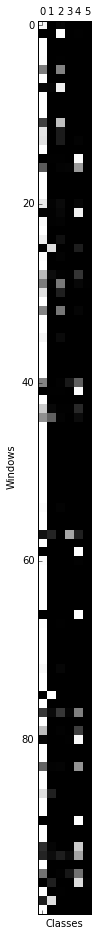

In [20]:
# Activations across windows
plt.gray()
plt.matshow(detection_df[labels].values[:100])
plt.xlabel('Classes')
plt.ylabel('Windows')

In [21]:
# Take maxima across windows
max_s = detection_df[labels].max(0)
max_s.sort(ascending=False)
threshold_dict = dict(zip(max_s.index, max_s.values))
print(max_s[:10])
print threshold_dict

car           1.000000
person        1.000000
background    1.000000
bicycle       0.999999
bus           0.999981
motorbike     0.449004
dtype: float32
{'bicycle': 0.9999994, 'motorbike': 0.44900396, 'bus': 0.99998081, 'person': 1.0, 'background': 1.0, 'car': 1.0}


In [22]:
def show_detections(im, indices, col_name, det_df, object_color = 'r'):
    # Show top detection in red.
    plt.imshow(im)
    currentAxis = plt.gca()
    for i in indices:
        #
        proba  = det_df[col_name][i]
        #
        window = det_df['window'][i]
        #
        ymin = window[0]
        xmin = window[1]
        ymax = window[2]
        xmax = window[3]
        coords = (xmin, ymin), xmax - xmin, ymax - ymin
        #
        currentAxis.add_patch(plt.Rectangle(*coords, fill=True, facecolor = object_color, edgecolor=object_color, linewidth=2, alpha = 0.1 * proba))
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, facecolor = object_color, edgecolor=object_color, linewidth=2, alpha = proba))

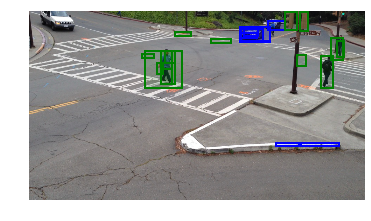

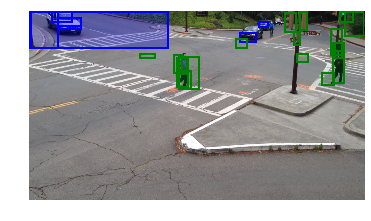

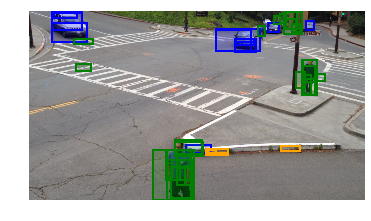

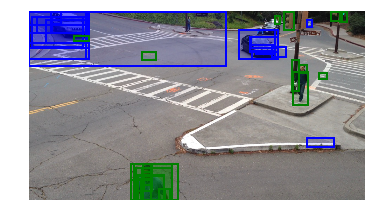

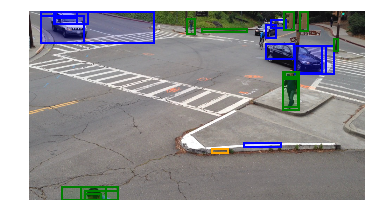

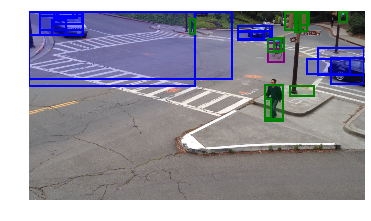

In [23]:
# Find, print, and display the top detections: car
colors = {'car' : 'blue',
          'person' : 'green',
          'bicycle' : 'purple',
          'bus' : 'orange',
          'motorbike' : 'pink'}

for image_index in range(len(fnames)):
    for target_object, object_color in colors.iteritems():
        sub_detection_df = detection_df[detection_df['filename'] == os.path.abspath(fnames[image_index])]
        indices = sub_detection_df[sub_detection_df[target_object] >= threshold].index.get_values()
        #indices = [sub_detection_df[target_object].argmax()]
        im = plt.imread(fnames[image_index])
        show_detections(im, indices, target_object, sub_detection_df, object_color)
    plt.axis('off')
    if BACKGROUND:
        plt.savefig('Multi_detect_%s_background_%s.png' % (hybrid_name, fnames[image_index].split('/')[-1]), dpi = 300)
    else:
        plt.savefig('Multi_detect_%s_no_background_%s.png' % (hybrid_name, fnames[image_index].split('/')[-1]), dpi = 300)
    plt.show()

In [24]:
if BACKGROUND:
    detection_df.to_csv('Detection_%s_background.png' % hybrid_name)
else:
    detection_df.to_csv('Detection_%s_no_background.png' % hybrid_name)

In [25]:
print BACKGROUND

True
